In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database, drop_database

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Store data as PostgreSQL Database

In [2]:
user_name = 'pablo'
db_name = 'funnel_analysis'
engine = sa.create_engine('postgresql://{}@localhost/{}'.format(user_name, db_name))

if not database_exists(engine.url):
    create_database(engine.url)
    
con = engine.connect()

In [74]:
# Home Page Table
chunks = pd.read_csv('Data/home_page_table.csv', chunksize=100000)
for chunk in chunks:
    chunk.to_sql(name='home_page', con=engine, if_exists='append')
    
# Payment Confirmation Table
chunks = pd.read_csv('Data/payment_confirmation_table.csv', chunksize=100000)
for chunk in chunks:
    chunk.to_sql(name='payment_confirmation', con=engine, if_exists='append')
    
# Payment Page Table
chunks = pd.read_csv('Data/payment_page_table.csv', chunksize=100000)
for chunk in chunks:
    chunk.to_sql(name='payment_page', con=engine, if_exists='append')
    
# Search Page Table
chunks = pd.read_csv('Data/search_page_table.csv', chunksize=100000)
for chunk in chunks:
    chunk.to_sql(name='search_page', con=engine, if_exists='append')
    
# User Table
chunks = pd.read_csv('Data/user_table.csv', chunksize=100000)
for chunk in chunks:
    chunk.to_sql(name='users', con=engine, if_exists='append')

In [3]:
pages = engine.table_names()
for page in pages:
    print(page)

home_page
payment_confirmation
payment_page
search_page
users


In [4]:
user_table = pd.read_sql_query('SELECT * FROM users', engine, index_col='index')
user_table.columns

Index(['user_id', 'date', 'device', 'sex'], dtype='object')

# User Breakdown

Men and women are equally represented. We can see that there is nearly a 1:1 ratio between female versus male users. Additionally, between men and women we see a similar ratio of desktop versus mobile access. Roughly 2/3 by gender use the desktop to access the services, and 1/3 use a mobile device.

In [5]:
female_users = pd.read_sql_query("SELECT * FROM users WHERE sex = 'Female'", engine, index_col='index')
male_users = pd.read_sql_query("SELECT * FROM users WHERE sex = 'Male'", engine, index_col='index')

In [6]:
female_users.shape[0] / male_users.shape[0]

0.9944842801985659

In [7]:
female_device_count = female_users['device'].value_counts()
male_device_count = male_users['device'].value_counts()

print('Female: ')
print(female_device_count / female_device_count.sum())
print()
print('Male: ')
print(male_device_count / male_device_count.sum())

Female: 
Desktop    0.665491
Mobile     0.334509
Name: device, dtype: float64

Male: 
Desktop    0.666365
Mobile     0.333635
Name: device, dtype: float64


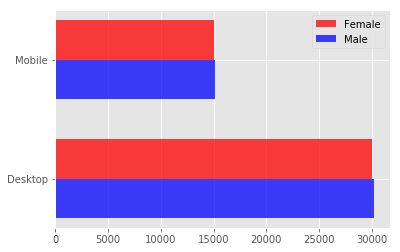

In [8]:
plt.barh(np.arange(2) + 0.33, female_device_count, 0.33, color='red', alpha=0.75, label='Female')
plt.barh(np.arange(2) + 0.0, male_device_count, 0.33, color='blue', alpha=0.75, label='Male')
plt.yticks(np.arange(2) + 0.33 / 2, ['Desktop', 'Mobile'])
plt.legend()
plt.show()

# Funnel Conversion Table

To evaluate the conversion between pages, we'll query the tables individually by joining the page tables to the user table. Each table will be loaded as a dataframe and appended to the full `user_access` dataframe.

In [10]:
# Dummy line incase you re-run the cell more than once
try:
    del user_access
except:
    pass

# Create query per page and append to data frame
for page in pages:
    query = """
    SELECT 
        users.index, 
        users.user_id, 
        users.date, 
        users.device, 
        users.sex, 
        page
    FROM {}
    LEFT JOIN users
    ON users.user_id = {}.user_id
    """.format(page, page)

    print(page)
    try:
        # Try to append to dataframe if it exists
        user_access = user_access.append(pd.read_sql_query(query, engine))
    except:
        # If dataframe does not exist, create it from query
        user_access = pd.read_sql_query(query, engine)

home_page
payment_confirmation
payment_page
search_page


# Aggregated Activity

We can immediately see that the majority of users arrive to the home page and search for products, however very few are purchasing products.

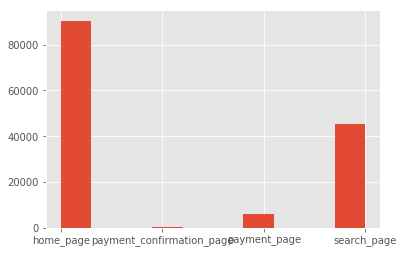

In [11]:
user_access['page'].hist()
plt.show()

# Time Series Evaluation

Let's evaluate the trends in the data by date. For simplicity the dates will represented as simple day, week, and month of the year. Any changes on user page activity can indicate potential sources of problems in the website.

In [12]:
user_access = pd.get_dummies(user_access, prefix='', prefix_sep='', columns=['page'])
user_access['date'] = pd.to_datetime(user_access['date'])

In [13]:
user_access['day'] = user_access['date'].apply(lambda x: x.dayofyear)
user_access['week'] = user_access['date'].apply(lambda x: x.week)
user_access['month'] = user_access['date'].apply(lambda x: x.month)
user_access['year'] = user_access['date'].apply(lambda x: x.year)

# Website Problems in March?

In the plot below, we can see that around the first day of March there is a huge drop in daily user activity. While we see this trend in the home page and confirmation page, it undoubtedly is most prominent in the search and then payment pages. This could be an indicator of site issues on that date. We'll continue to explore what may have occured.

In [14]:
import calendar

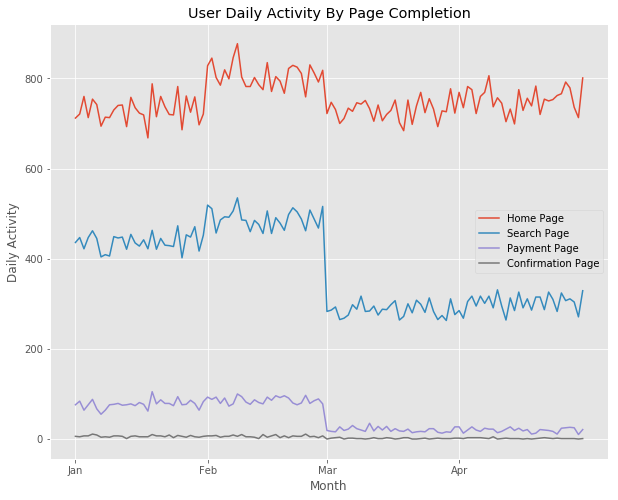

In [15]:
daily_events = user_access.groupby('day').sum()

plt.figure(figsize=(10, 8))
plt.plot(daily_events.index, daily_events['home_page'], label='Home Page')
plt.plot(daily_events.index, daily_events['search_page'], label='Search Page')
plt.plot(daily_events.index, daily_events['payment_page'], label='Payment Page')
plt.plot(daily_events.index, daily_events['payment_confirmation_page'], label='Confirmation Page')

plt.title('User Daily Activity By Page Completion')
plt.xlabel('Month')
plt.ylabel('Daily Activity')
plt.xticks(user_access.groupby('month').min()['day'], np.array(calendar.month_abbr)[sorted(user_access['month'].unique())])
plt.legend()
plt.show()

# Sources of Site Issues?

While the source is still unknown, with the limited dataset we can only really evaluate if the issue is specific to user device or the user's gender. Maybe the website had issues with its desktop platform, or maybe an ad was offensive and caused a reduction in sales by gender.

In [54]:
# Manually split tables by gruops
groups = []
for sex in user_access['sex'].unique():
    for device in user_access['device'].unique():
        groups.append(user_access[np.logical_and(user_access['sex'] == sex, user_access['device'] == device)])

In [68]:
# Aggregate by sum of events
female_desktop = groups[0].groupby('day').sum()
female_mobile = groups[1].groupby('day').sum()
male_desktop = groups[2].groupby('day').sum()
male_mobile = groups[3].groupby('day').sum()

### Search Page Conversion

As a first search, we'll evaluate what the ocnversion rate was for users who went from the home page to a search page. We can see that there is no distinction by gender, but that for men and women the mobile device had a large drop. To evaluate trends, we employ k-Nearest-Neighbors to smooth over a 2-week period. 

In [74]:
from sklearn.neighbors import KNeighborsRegressor

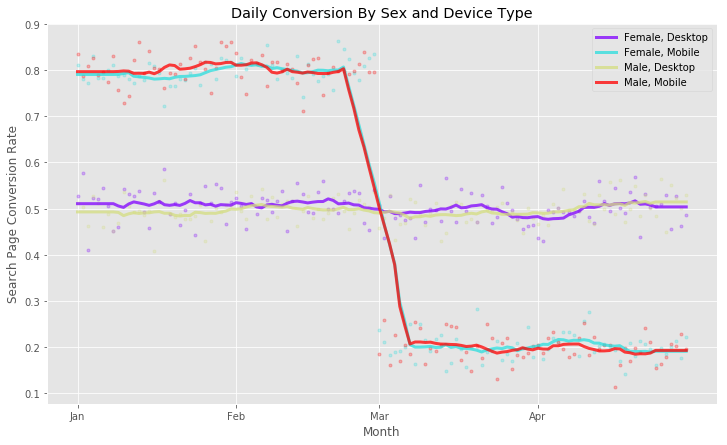

In [109]:
# Average over 2 Weeks
n_neighbors = 14
color = plt.cm.rainbow(np.linspace(0, 1, 4))
plt.figure(figsize=(12, 7))

### Plot raw data points
plt.plot(female_desktop['search_page'] / female_desktop['home_page'], '.', color=color[0], alpha=0.25)
plt.plot(female_mobile['search_page'] / female_mobile['home_page'], '.', color=color[1], alpha=0.25)
plt.plot(male_desktop['search_page'] / male_desktop['home_page'], '.', color=color[2], alpha=0.25)
plt.plot(male_mobile['search_page'] / male_mobile['home_page'], '.', color=color[3], alpha=0.25)

### Filter trendline by k-Nearest-Neighbors
# Female, Desktop
X, y = np.array(female_desktop.index).reshape(-1, 1), female_desktop['search_page'] / female_desktop['home_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[0], alpha=0.75, label="Female, Desktop")

# Female, Mobile
X, y = np.array(female_mobile.index).reshape(-1, 1), female_mobile['search_page'] / female_mobile['home_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[1], alpha=0.75, label="Female, Mobile")

# Male, Desktop
X, y = np.array(male_desktop.index).reshape(-1, 1), male_desktop['search_page'] / male_desktop['home_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[2], alpha=0.75, label="Male, Desktop")

# Male, Mobile
X, y = np.array(male_mobile.index).reshape(-1, 1), male_mobile['search_page'] / male_mobile['home_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[3], alpha=0.75, label="Male, Mobile")

### Set Axes
plt.title('Daily Conversion By Sex and Device Type')
plt.xlabel('Month')
plt.ylabel('Search Page Conversion Rate')
plt.xticks(user_access.groupby('month').min()['day'], np.array(calendar.month_abbr)[sorted(user_access['month'].unique())])
plt.legend()
plt.show()

### Payment Page Conversion

In the conversion between search to payment page, we see that here the issue was dependent on the mobile platform.

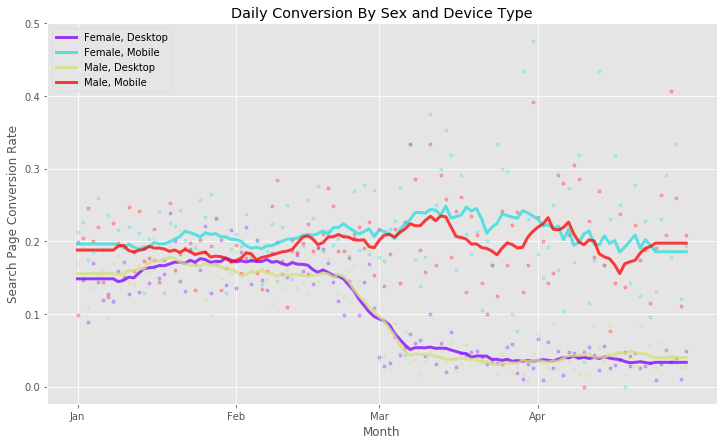

In [105]:
n_neighbors = 14
color = plt.cm.rainbow(np.linspace(0, 1, 4))

plt.figure(figsize=(12, 7))
plt.plot(female_desktop['payment_page'] / female_desktop['search_page'], '.', color=color[0], alpha=0.25)
plt.plot(female_mobile['payment_page'] / female_mobile['search_page'], '.', color=color[1], alpha=0.25)
plt.plot(male_desktop['payment_page'] / male_desktop['search_page'], '.', color=color[2], alpha=0.25)
plt.plot(male_mobile['payment_page'] / male_mobile['search_page'], '.', color=color[3], alpha=0.25)

# Female, Desktop
X, y = np.array(female_desktop.index).reshape(-1, 1), female_desktop['payment_page'] / female_desktop['search_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[0], alpha=0.75, label="Female, Desktop")

# Female, Mobile
X, y = np.array(female_mobile.index).reshape(-1, 1), female_mobile['payment_page'] / female_mobile['search_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[1], alpha=0.75, label="Female, Mobile")

# Male, Desktop
X, y = np.array(male_desktop.index).reshape(-1, 1), male_desktop['payment_page'] / male_desktop['search_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[2], alpha=0.75, label="Male, Desktop")

# Male, Mobile
X, y = np.array(male_mobile.index).reshape(-1, 1), male_mobile['payment_page'] / male_mobile['search_page']
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[3], alpha=0.75, label="Male, Mobile")

plt.title('Daily Conversion By Sex and Device Type')
plt.xlabel('Month')
plt.ylabel('Search Page Conversion Rate')
plt.xticks(user_access.groupby('month').min()['day'], np.array(calendar.month_abbr)[sorted(user_access['month'].unique())])
plt.legend()
plt.show()

### Confirmation Page Conversion

While the raw data is difficult to evaluate, we can see from the filtered trendlines that there is no significant change in trend. For users who did not have device issues they were able to complete purchases.  

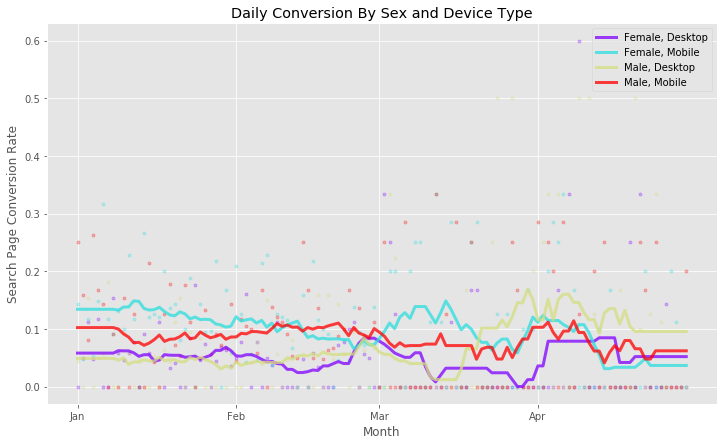

In [116]:
n_neighbors = 14
color = plt.cm.rainbow(np.linspace(0, 1, 4))

plt.figure(figsize=(12, 7))
plt.plot(female_desktop['payment_confirmation_page'] / female_desktop['payment_page'], '.', color=color[0], alpha=0.25)
plt.plot(female_mobile['payment_confirmation_page'] / female_mobile['payment_page'], '.', color=color[1], alpha=0.25)
plt.plot(male_desktop['payment_confirmation_page'] / male_desktop['payment_page'], '.', color=color[2], alpha=0.25)
plt.plot(male_mobile['payment_confirmation_page'] / male_mobile['payment_page'], '.', color=color[3], alpha=0.25)

# Female, Desktop
X, y = np.array(female_desktop.index).reshape(-1, 1), female_desktop['payment_confirmation_page'] / female_desktop['payment_page']
y = y.replace(np.nan, 0)
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[0], alpha=0.75, label="Female, Desktop")

# Female, Mobile
X, y = np.array(female_mobile.index).reshape(-1, 1), female_mobile['payment_confirmation_page'] / female_mobile['payment_page']
y = y.replace(np.nan, 0)
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[1], alpha=0.75, label="Female, Mobile")

# Male, Desktop
X, y = np.array(male_desktop.index).reshape(-1, 1), male_desktop['payment_confirmation_page'] / male_desktop['payment_page']
y = y.replace(np.nan, 0)
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[2], alpha=0.75, label="Male, Desktop")

# Male, Mobile
X, y = np.array(male_mobile.index).reshape(-1, 1), male_mobile['payment_confirmation_page'] / male_mobile['payment_page']
y = y.replace(np.nan, 0)
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
plt.plot(X, knn.predict(X), linewidth=3, color=color[3], alpha=0.75, label="Male, Mobile")

plt.title('Daily Conversion By Sex and Device Type')
plt.xlabel('Month')
plt.ylabel('Search Page Conversion Rate')
plt.xticks(user_access.groupby('month').min()['day'], np.array(calendar.month_abbr)[sorted(user_access['month'].unique())])
plt.legend()
plt.show()

# Final Conclusions

While the exact cause is unknown, there were clearly some device-platform issues for the site on the first day of March. Unfortunately, the effects doubly impacted the website as desktop users had limited access to search results, and mobile users to the purchase page. 

As the lower stationary trend persisted in the month of April, either the error still remains or customers may have been lost due to the poor performance. 